<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/product-analytics/product_retention_curves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Growth Models - Product Retention Curves

In order to grow systematically, a growth team needs to understand the fundamental structure of it's product's user base.

## Visualizing growth

The building block of growth is the retention profile: the rate at wchich a cohort decays over time. Looking at a single retention profile in isolation, it's easy to understand how a user base made up of many cohorts can grow over time. 

In [0]:
#@title ## Install dependencies
#@markdown * beatifultable

!pip install beautifultable -q

In [0]:
#@title ## Plotting utilities
#@markdown TODO: document

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as pltcolors
import pandas as pd
import numpy as np
import random
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors as mcolors
from matplotlib import cm
from beautifultable import BeautifulTable
from datetime import datetime
from datetime import timedelta
from scipy.stats import linregress

this_date = datetime.now()

def stacked_bar( data, series_labels, category_labels=None, 
                show_values=False, value_format="{}", y_label=None, 
                grid=True, reverse=False, show_totals_values=False, totals = [],
                colors=[] ):
    """Plots a stacked bar chart with the data and labels provided.

    Keyword arguments:
    data            -- 2-dimensional numpy array or nested list
                       containing data for each series in rows
    series_labels   -- list of series labels (these appear in
                       the legend)
    category_labels -- list of category labels (these appear
                       on the x-axis)
    show_values     -- If True then numeric value labels will 
                       be shown on each bar
    value_format    -- Format string for numeric value labels
                       (default is "{}")
    y_label         -- Label for y-axis (str)
    grid            -- If True display grid
    reverse         -- If True reverse the order that the
                       series are displayed (left-to-right
                       or right-to-left)
    """

    plt.figure( figsize = (25, 15) )
    
    ny = len(data[0])
    ind = list( range(ny) )

    axes = []
    cum_size = np.zeros( ny )

    data = np.array( data )

    if reverse:
        data = np.flip(data, axis=1)
        category_labels = reversed(category_labels)

    for i, row_data in enumerate( data ):
        if colors:
            axes.append( plt.bar( ind, row_data, bottom=cum_size, 
                                label=series_labels[i], color = colors[ i ] ) )
        else:
            axes.append( plt.bar( ind, row_data, bottom=cum_size, 
                                label=series_labels[i] ) )
        cum_size += row_data

    if category_labels:
        category_font_size = 20 if len( category_labels ) <= 15 else 16
        plt.xticks( ind, category_labels, fontsize=category_font_size )
        plt.xticks( rotation=45 )

    if y_label:
        plt.ylabel( y_label, fontsize=20 )
        plt.yticks( fontsize=20 )

    plt.legend( fontsize = 'xx-large' )

    if grid:
        plt.grid()

    if show_values:
        for axis in axes:
            for bar in axis:
                w, h = bar.get_width(), bar.get_height()
                if h != 0:
                    plt.text( bar.get_x() + w/2, bar.get_y() + h/2, 
                             h, ha="center", 
                             va="center", fontsize=22 )
                    
    if show_totals_values:
        #show the total for each stacked bar chart
        #eg. the sum of the values for any given category
        if totals:
            if len( totals ) == len( category_labels ):
                for index, total in enumerate( totals ):
                    totals_font = 26 if len( category_labels ) <= 15 else 18
                    totals_rotate = 0 if len( category_labels ) <= 15 else 45
                    totals_height = 3 if len( category_labels ) <= 15 else 10
                    plt.text( index, total + ( totals_height/100 * sum( totals ) / len( totals ) ), 
                             total, ha="center", 
                             va="center", fontsize=totals_font, color="r", 
                             weight = 'bold', rotation=totals_rotate )

def build_cohort_DAU_map( cohort, map_length ):
    DAU = [ 0 ] * map_length
    for x in range( 0, map_length ):
        DAU[ x ] = int( cohort[ 'cohort_size' ] * np.exp( cohort[ 'retention_profile' ][ 1 ] * x ) )
    return DAU

def build_cohort( cohorts, date, cohort_size, retention_profile, color = None ):
    cohort = pd.DataFrame( columns=[ 'date', 'retention_profile', 'cohort_size', 'color' ] )
    if color is None:
        color = random.choice( colors )
    if not cohorts.empty:
        while color in cohorts[ 'color' ].tolist():
            color = random.choice( colors )
    cohort.loc[ 0 ] = [ date.date(), retention_profile, cohort_size, color ]
    return cohort

def create_cohorts( cohorts_DNU ):
    cohorts = pd.DataFrame()
    for i, value in enumerate( cohorts_DNU ): 
        cohort_size = cohorts_DNU[ i ][ 'DNU' ]
        cohort = build_cohort( cohorts, ( this_date + timedelta( days = i ) ) , cohort_size, retention_profiles[ 0 ], color = cohorts_DNU[ i ][ 'color' ] )
        cohorts = cohorts.append( cohort )
    return cohorts

def add_cohort( cohorts, date, cohort_size, retention_profile ):
    this_cohort = build_cohort( cohorts, date, cohort_size, retention_profile )
    cohorts = cohorts.append( this_cohort )
    return cohorts

def plot_DAU( DAU ):
    fig, ax1 = plt.subplots()
    plt.rcParams[ 'figure.figsize' ] = [ 10, 5 ]
    ax1.set_ylabel( 'DAU' )
    ax1.plot( np.arange( len( DAU ) ), DAU, label='DAU', color='#ff4d4d' )
    ax1.legend( loc='center right' )
    fig.suptitle( 'DAU', fontsize=14 )
    vals = ax1.get_yticks()
    gap_size = 90
    ax1.annotate('(Day: %s, DAU: %s)' % 
        ( 0, int( DAU[ 0 ] ) ), xy=( 0, int( DAU[ 0 ] ) ), textcoords='data')
    for x in range( 1, int( ( len( DAU ) - 1 ) / gap_size ) ):
        ax1.annotate('(Day: %s, DAU: %s)' % 
            ( x * gap_size, int( DAU[ x * gap_size ] ) ), xy=( x * gap_size, int( DAU[ x * gap_size ] ) ), textcoords='data')
    ax1.annotate('(Day: %s, DAU: %s)' % 
        ( len( DAU ) - 1, int( DAU[ len( DAU ) - 1 ] ) ), xy=( len( DAU ) - 1, int( DAU[ len( DAU ) - 1 ] ) ), textcoords='data')
    plt.grid()
    plt.show()
    
    print_DAU_table( DAU, DAU[ 0 ] )
    
def print_DAU_table( DAU, cohort_size ):
    table = BeautifulTable()
    table.column_headers = [ "Day", "DAU", "Needed Replacement" ]
    table.append_row( [ 0, int( DAU[ 0 ] ), cohort_size - int( DAU[ 0 ] ) ] )
    gap_size = 90
    for x in range( 1, int( ( len( DAU ) - 1 ) / gap_size ) ):
        table.append_row( [ x * gap_size, int( DAU[ x * gap_size ] ), cohort_size - int( DAU[ x * gap_size ] ) ] )
    table.append_row( [ len( DAU ) - 1, int( DAU[ len( DAU ) - 1 ] ), cohort_size - int( DAU[ len( DAU ) - 1 ] ) ] )
    
    print( table )
    
def plot_DNU( DNU ):
    fig, ax1 = plt.subplots()
    plt.rcParams[ 'figure.figsize' ] = [ 10, 5 ]
    ax1.set_ylabel( 'DNU' )
    ax1.bar( np.arange( len( DNU ) ), DNU, label='DNU', color='#ff4d4d' )
    ax1.legend( loc='center right' )
    fig.suptitle( 'DNU', fontsize=14 )
    vals = ax1.get_yticks()
    
    #add data labels to the bars
    rects = ax1.patches
    for rect, label in zip( rects, DNU ):
        height = rect.get_height()
        ax1.text( rect.get_x() + rect.get_width() / 2, height + 5, label,
                ha='center', va='bottom' )
    ##

    plt.grid()
    plt.show()
    
def print_retention_table( retention_profile ):
    table = BeautifulTable()
    table.column_headers = [ "Day", "Retention %" ]
    table.append_row( [ 0, int( retention_profile[ 0 ] ) ] )
    table.append_row( [ 1, int( retention_profile[ 1 ] ) ] )
    table.append_row( [ 30, int( retention_profile[ 30 ] ) ] )
    table.append_row( [ 60, int( retention_profile[ 60 ] ) ] )
    table.append_row( [ 360, int( retention_profile[ 360 ] ) ] )
    
    print( table )
    
def plot_retention_profile( retention_profile ):
    x = np.arange( 0, 364, 1 ) 
    this_profile = np.exp( retention_profile[ 1 ] * x ) * 100
    
    fig, ax1 = plt.subplots()
    plt.rcParams[ 'figure.figsize' ] = [ 10, 5 ]
    ax1.set_ylabel( 'Retention' )
    ax1.plot( this_profile, '-r', label='Retention %' )
    ax1.legend( loc='center right' )
    fig.suptitle( 'Retention Profile', fontsize=14 )
    vals = ax1.get_yticks()
    ax1.set_yticklabels( [ '%1.2f%%' %i for i in vals ] )
    plt.grid()
    plt.show()
    print_retention_table( this_profile )
    
def build_forward_DAU( cohorts, map_length ):
    map_length += len( cohorts )
    start_date = min( cohorts[ 'date' ] )
    today = start_date + timedelta( days = ( map_length ) ) 
    #map_length should include original cohort days, so add in the length of the cohorts
    dates = pd.date_range( start_date, periods = map_length ).tolist()
    dates = [ str( d.date() ) for d in dates ]
    forward_DAU = pd.DataFrame( columns = [ 'cohort_date' ] + dates )
    for index, value in cohorts.iterrows():
        this_date = value[ 'date' ]
        this_cohort = pd.DataFrame( columns = [ 'cohort_date' ] + dates )
        this_cohort.loc[ 0, 'cohort_date' ] = this_date
        i = 0
        while this_date < today:
            this_cohort.loc[ 0, str( this_date ) ]  = int( value[ 'cohort_size' ] * np.exp( value[ 'retention_profile' ][ 1 ] * i ) )
            this_date = this_date + timedelta( days = 1 )
            i += 1
        forward_DAU = forward_DAU.append( this_cohort )
        forward_DAU = forward_DAU.fillna( 0 )
    return ( forward_DAU, dates )

def plot_DNU_retention_map( cohorts ):
    
    forward_DAU, forward_DAU_dates = build_forward_DAU( cohorts, len( cohorts ) )
    cohort_days = [ forward_DAU[ x ].tolist() for x in forward_DAU.columns ]
    cohort_data = np.array( cohort_days[ 1: ] )

    column_names = forward_DAU_dates
    row_names = forward_DAU_dates

    fig = plt.figure( figsize = (25, 15) )
    ax = Axes3D( fig )

    lx = len( cohort_data[0] )     # Work out matrix dimensions
    ly = len( cohort_data[ :, 0 ] )
    xpos = np.arange( 0, lx, 1 )    # Set up a mesh of positions
    ypos = np.arange( 0, ly, 1 )
    xpos, ypos = np.meshgrid( xpos, ypos )

    xpos = xpos.flatten( )   # Convert positions to 1D array
    ypos = ypos.flatten( )
    zpos = np.zeros( lx * ly )

    dx = 0.5 * np.ones_like( zpos )
    dy = dx.copy()
    dz = cohort_data.flatten()
    
    plot_colors = cohorts[ 'color' ].tolist() * ly

    ax.bar3d( xpos, ypos, zpos, dx, dy, dz, color = plot_colors, shade=True, alpha=0.4 )
    
    max_value = max( [ [ max( DAU ) ] for DAU in cohort_data ] )[ 0 ]
    #get the max value from the entire DAU map and use that for plotting the text
    #otherwise the text gets obscured by the other graphs for cohorts with low starting DAU
    
    #print the DNU values, eg. the first value of each series   
    for ( x, y ), value in np.ndenumerate( cohort_data ):
        if x == y:
            ax.text( x, y, ( max_value / 2 ), value, color='#FFFFFF', fontsize=40 )

    ax.w_xaxis.set_ticklabels( column_names )
    ax.w_yaxis.set_ticklabels( row_names )
    ax.set_xlabel( 'Cohort Date', fontsize=40, labelpad=80 )
    ax.set_ylabel( 'Day', fontsize=40, labelpad=80 )
    ax.set_zlabel( 'DAU', fontsize=40, labelpad=60 )
    plt.tick_params( axis='both', which='major', labelsize=20 )

    plt.show()
    
def plot_forward_DAU_stacked( forward_DAU, forward_DAU_dates, show_values=False, show_totals_values=False, cohorts = None ):
    transformed = forward_DAU.values.tolist()

    for index, value in enumerate( transformed ):
       transformed[ index ] = value[ 1: ]
    
    totals = [ forward_DAU[ column ].sum() for column  
        in forward_DAU.loc[ :, forward_DAU.columns != 'cohort_date' ] ]
    
    if cohorts is not None:
        if not cohorts.empty:
            colors = cohorts[ 'color' ].tolist()
        else:
            print( "error: cohorts empty" )
    else:
        print( "error: cohorts weren't sent" )

    stacked_bar( transformed, forward_DAU_dates[ 0: len( transformed ) ], category_labels=forward_DAU_dates, 
        show_values=show_values, value_format="{}", y_label='DAU', 
        grid=True, reverse=False, show_totals_values=show_totals_values, totals = totals, colors = colors )
    
def build_DAU_trajecory( start_DAU, end_DAU, periods ):
    x = [ 1, periods ]
    y = [ start_DAU, end_DAU ]
    
    model = linregress( x, y )
    
    return model

def plot_projections_example( start_DAU, end_DAU, periods, DAU_values=[] ):
    if not DAU_values:
        y = periods * [ 0 ]
        y[ 0 ] = start_DAU
        y[ len( y ) - 1 ] = end_DAU
    else:
        y = DAU_values
        
    x = [ str( i ) for i in range( 1, len( y ) + 1 ) ]
    
    fig, ax1 = plt.subplots()
    plt.rcParams[ 'figure.figsize' ] = [ 10, 5 ]
    ax1.set_ylabel( 'DAU' )
    ax1.bar( x, y, label='DAU', color='#ff4d4d' )
    ax1.legend( loc='center right' )
    fig.suptitle( 'DAU', fontsize=14 )

    #add data labels to the bars
    rects = ax1.patches
    for rect, label in zip( rects, y ):
        height = rect.get_height()
        ax1.text( rect.get_x() + rect.get_width() / 2, height + 5, int( label ),
                ha='center', va='bottom' )
    ##
    
    ax1.set_xticklabels( x )

    plt.grid()
    plt.show()
    
def print_trailing_cohort_DNU_table( cohorts, periods ):
    
    replacement_DNU = cohorts[ ( -1 * periods ): ][ [ 'date', 'cohort_size' ] ]
    
    table = BeautifulTable()
    table.column_headers = replacement_DNU.columns.tolist()

    for index, row in replacement_DNU.iterrows():
        table.append_row( row )
    
    print( table )
    
def build_DAU_projection_map( cohorts, retention_profiles, forward_DAU, DAU_values ):
    
    this_DAU_value = DAU_values[ 0 ]
    this_date_value = datetime.strptime( forward_DAU.columns.tolist()[ -1 ] , '%Y-%m-%d' ) + timedelta( days = 1 )
    
    #advance the cohorts forward by one day to see what the natural DAU 
    #from existing cohorts would be without any additions
    forward_DAU, forward_DAU_dates = build_forward_DAU( cohorts, 1 )
    natural_DAU = forward_DAU.iloc[ :, -1 ].sum()
    
    #calculate replacement DAU needed to hit the DAU goal
    replacement_DAU = this_DAU_value - natural_DAU
    #add this new cohort on this day IF the replacement DAU is positive
    cohorts = add_cohort( cohorts, this_date_value, ( 0 if replacement_DAU < 0 else replacement_DAU ), 
        retention_profiles[ 0 ] )
        
    #advance the cohorts, including the new cohort, forward by one day
    forward_DAU, forward_DAU_dates = build_forward_DAU( cohorts, 0 )
    
    #if this was the last DAU target to hit, return the values
    if len( DAU_values ) == 1:
        return cohorts
    #if there are more DAU targets left to hit, remove this target and run the process again recursively
    return build_DAU_projection_map( cohorts, retention_profiles, forward_DAU, DAU_values[ 1: ] )

def run_simulation( forward_DAU, DAU_target, periods, cohorts ):
    ###start projections
    start_DAU = forward_DAU.iloc[ :, -1].sum() #the current value of DAU

    model = build_DAU_trajecory( start_DAU, DAU_target, periods )
    ###end projections

    ###plot a projection example
    plot_projections_example( start_DAU, DAU_target, periods )

    DAU_values = [ model[ 0 ] * i + model[ 1 ] for i in range( 1, periods + 1 ) ]
    #start from 2 because we want to exclude the first value, which is the last value of the existing cohorts

    plot_projections_example( start_DAU, DAU_target, periods, DAU_values )

    cohorts = build_DAU_projection_map( cohorts, retention_profiles, forward_DAU, DAU_values[ 1: ] )
    forward_DAU, forward_DAU_dates = build_forward_DAU( cohorts, 0 )

    plot_forward_DAU_stacked( forward_DAU, forward_DAU_dates, show_values=True, 
        show_totals_values=True, cohorts = cohorts )

    print_trailing_cohort_DNU_table( cohorts, periods - 1 )


## Setup

In [0]:
cmap = cm.get_cmap( 'tab20', 100 )    # PiYG, create a color map
colors = [ pltcolors.rgb2hex( cmap( i )[ :3 ] ) for i in range( cmap.N ) ] 

retention_profiles = [ [ 0, -.008, 1 ] ] 
#the retention profile that each cohort will take
#the larger the absolute value of the 2nd element, the steeper the curve
cohorts_DNU = [ { "DNU": 5482, "color": "#E4814F" },
    { "DNU": 6812, "color": "#C1CB69" },
    { "DNU": 4938, "color": "#4D7F71" },
    { "DNU": 5028, "color": "#DFD59A" },
    { "DNU": 3058, "color": "#EDA646" } ]

base_cohorts = create_cohorts( cohorts_DNU )
this_date = datetime.now()

#the initial forward_DAU calculation, it creates the stacked cohorts
#but doesn't advance them further than the number of cohorts
# (eg. only the original cohorts are included but they are all projected forward
# to the end of this cohort series)
base_forward_DAU, base_forward_DAU_dates = build_forward_DAU( base_cohorts, 0 )
#an example DAU map for one cohort
cohort_DAU = build_cohort_DAU_map( base_cohorts.iloc[ 0 ], 365 )

## Exploratory Analysis

In [22]:
retention_profiles[0]

[0, -0.008, 1]

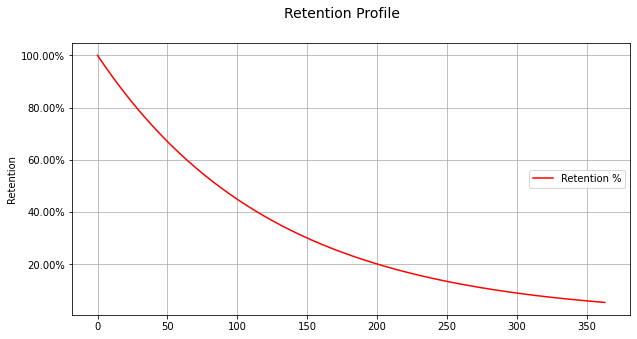

+-----+-------------+
| Day | Retention % |
+-----+-------------+
|  0  |     100     |
+-----+-------------+
|  1  |     99      |
+-----+-------------+
| 30  |     78      |
+-----+-------------+
| 60  |     61      |
+-----+-------------+
| 360 |      5      |
+-----+-------------+


In [11]:
plot_retention_profile( retention_profiles[ 0 ] )

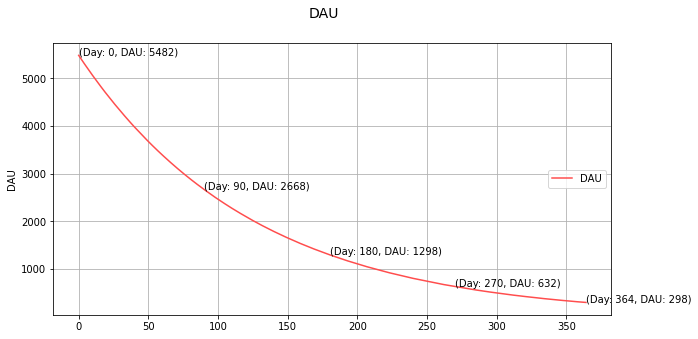

+-----+------+--------------------+
| Day | DAU  | Needed Replacement |
+-----+------+--------------------+
|  0  | 5482 |         0          |
+-----+------+--------------------+
| 90  | 2668 |        2814        |
+-----+------+--------------------+
| 180 | 1298 |        4184        |
+-----+------+--------------------+
| 270 | 632  |        4850        |
+-----+------+--------------------+
| 364 | 298  |        5184        |
+-----+------+--------------------+


In [13]:
plot_DAU( cohort_DAU )

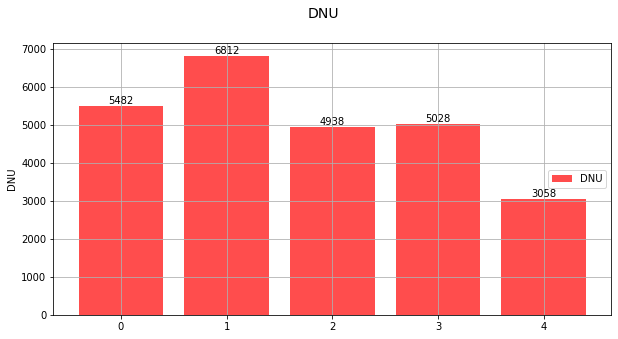

In [14]:
plot_DNU( list( base_cohorts[ 'cohort_size' ] ) )


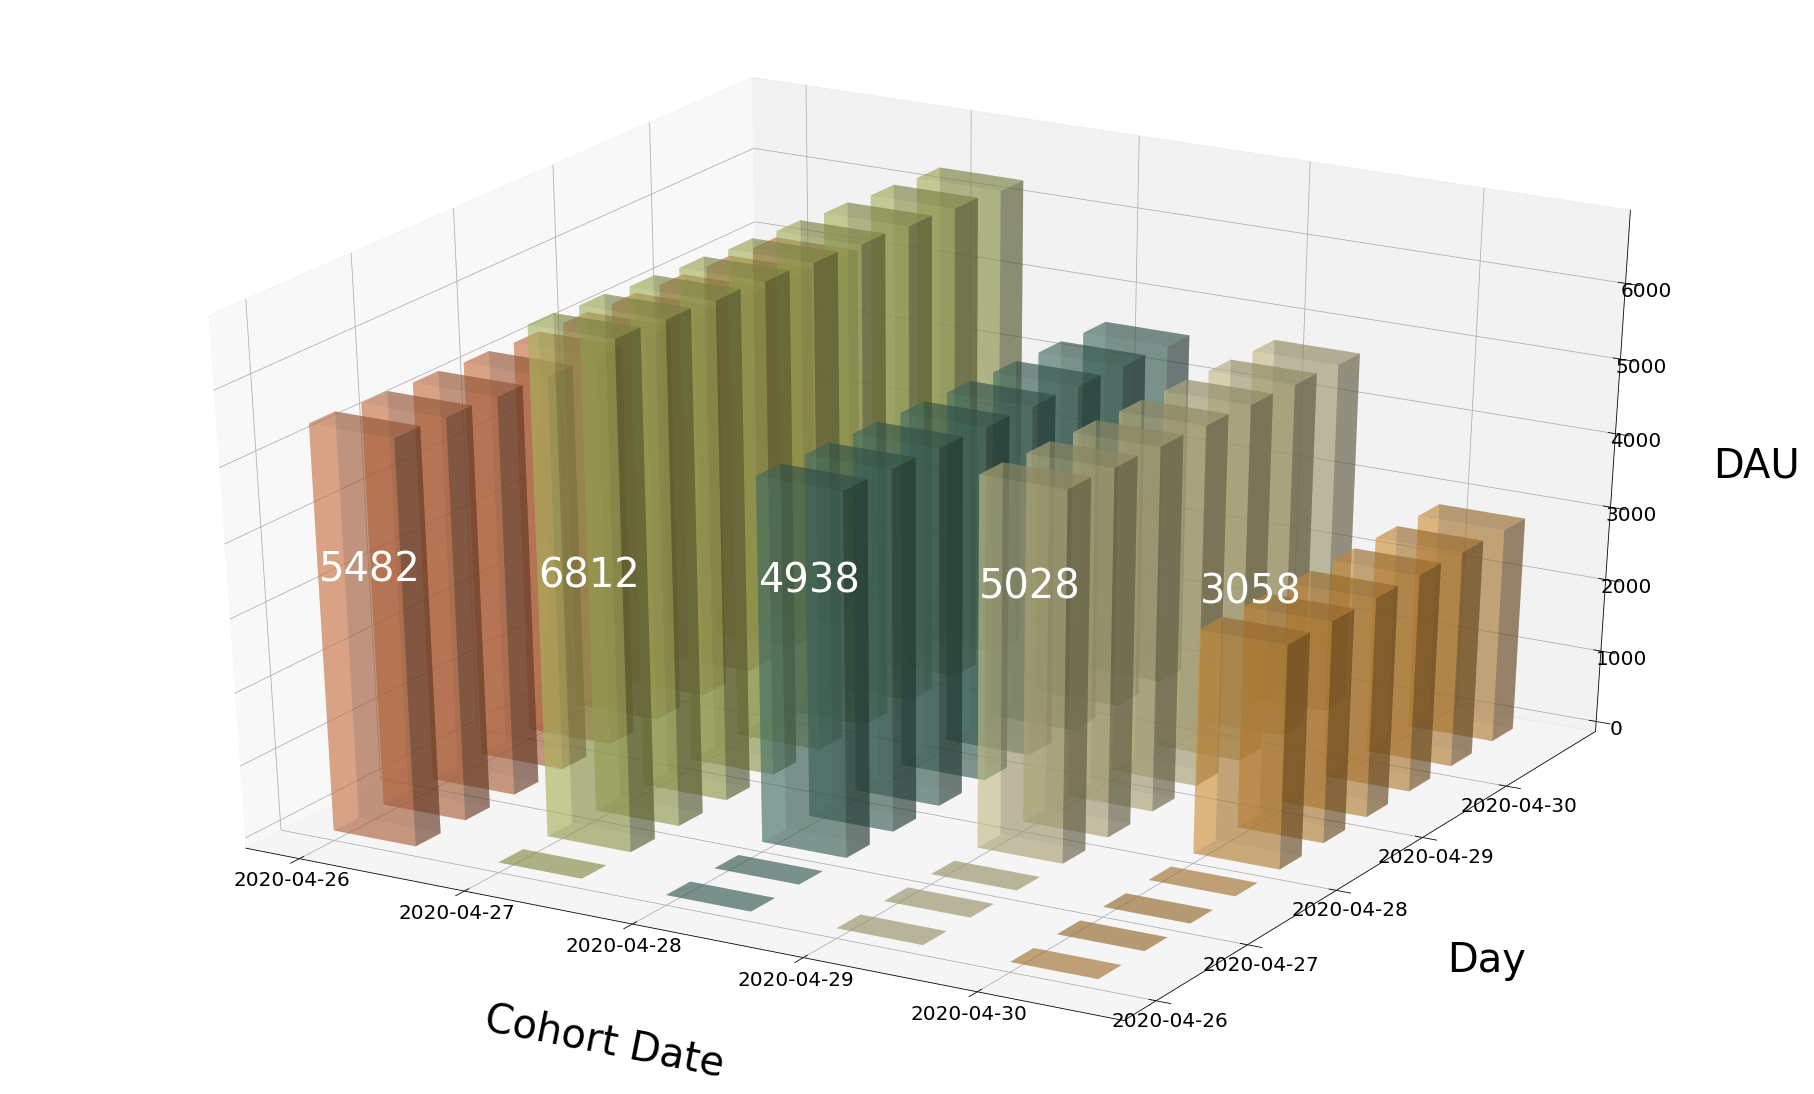

In [15]:
plot_DNU_retention_map( base_cohorts )


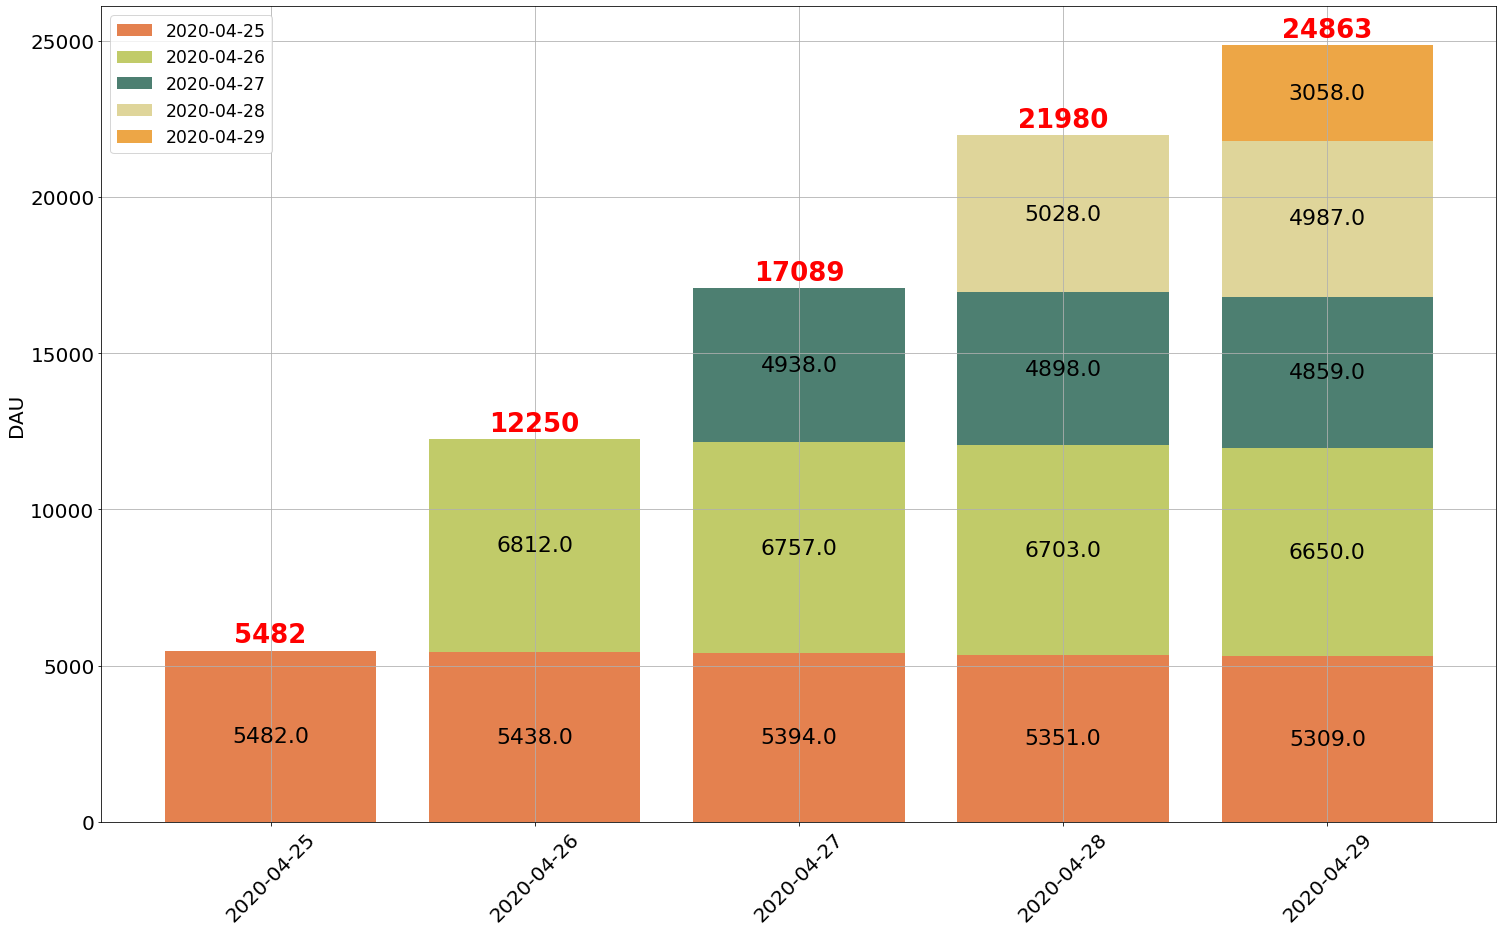

In [16]:
plot_forward_DAU_stacked( base_forward_DAU, base_forward_DAU_dates, 
    show_values=True, show_totals_values=True, cohorts=base_cohorts )

In [0]:
###show what the base cohorts would evolve to over 15 periods without any NEW cohorts
example_forward_DAU, example_forward_DAU_dates = build_forward_DAU( base_cohorts, 15 )
plot_forward_DAU_stacked( example_forward_DAU, example_forward_DAU_dates, show_values=True, 
    show_totals_values=True, cohorts = base_cohorts )

###simulations
#first simulation: growing to 50000 DAU after 15 periods
run_simulation( base_forward_DAU, 50000, 15, base_cohorts ) 


In [0]:
#second simulation: maintaining the same DAU over 15 periods
run_simulation( base_forward_DAU, base_forward_DAU.iloc[ :, -1].sum(), 15, base_cohorts ) 
#third simulation: DAU declines to just 15000 over 15 periods


In [0]:
run_simulation( base_forward_DAU, 22500, 15, base_cohorts ) 
###end simulations